# Введение

Нам необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам интернет-магазина «В один клик», чтобы увеличить их покупательскую активность. Для этого проанализируем, что влияет на пользовательскую активность и произведем сегментацию покупателей. 

Магазин предоставил следующие данные:
- market_file.csv
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- market_money.csv
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

- market_time.csv
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- money.csv
Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.




## Импорт библиотек

In [3]:
!pip install -q imblearn
!pip install -q phik
!pip install -q shap
!pip install -q optuna
!pip install -q optuna.integration
!pip install -qU scikit-learn imbalanced-learn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import phik
from imblearn.over_sampling import SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score
from optuna import distributions
from optuna.integration import OptunaSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance
import shap
import math

## Загрузка данных

In [5]:
market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal = ',')
market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal = ',')
market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

In [6]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [10]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null   object
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  Ошибка_сервиса                       1300 n

In [11]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   Период   3900 non-null   object
 2   Выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB


In [12]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Данные загружены. Пропусков не обнаружено, данные в таблицах соответствуют описанию, но нужно изменить тип некоторых стобцов на числовой для дальнейшего удобства. На следующем шаге мы займемся предобработкой данных, где как раз и займемся этим преобразованием. 

## Предобработка данных

Для начала изменим тип данных на числовой в столбцах, где хранятся числа. 

In [14]:
df = ['Маркет_актив_6_мес', 'Акционные_покупки']
for i in df:
    market_file[i] = pd.to_numeric(market_file[i], errors='coerce')
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [15]:
df = ['Выручка']
for i in df:
    market_money[i] = pd.to_numeric(market_money[i], errors='coerce')
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Теперь типы данных соответсвут значениям, дальше нам необходимо проверить наличие дубликатов, начнем с явных. 

In [16]:
print('market_file: ', market_file.duplicated().sum())
print('market_money: ', market_money.duplicated().sum())
print('market_time: ', market_time.duplicated().sum())
print('money: ', money.duplicated().sum())

market_file:  0
market_money:  0
market_time:  0
money:  0


Строки, полностью совпадающие, отсутствуют во всех таблицах. Значения в одном столбце могут повторяться, но это не ошибка, поскольку данные такого типа как у нас, могут повторять друг друга, однако проверим уникальные значения в нечисловых столбцах, чтобы удостовериться в отсутствии опечаток. 

In [17]:
df_market_file = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
df_market_money_time = ['Период']

for i in df_market_file:
    print(market_file[i].value_counts())
    
print(market_money[df_market_money_time].value_counts())
print(market_time[df_market_money_time].value_counts())

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64
стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64
да     962
нет    338
Name: Разрешить сообщать, dtype: int64
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64
Период             
предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
dtype: int64
Период          
предыдцщий_месяц    1300
текущий_месяц       1300
dtype: int64


Итак, в таблице market_file в столбце Тип сервиса нашлась орфографическая ошибка, которая привела бы к дубликату, исправим стандартт на стандарт. В таблице market_time также есть орфографическая ошибка: предыдцщий_месяц исправим на предыдущий_месяц.

In [18]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

print(market_file['Тип сервиса'].value_counts())
print(market_time['Период'].value_counts())

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64
предыдущий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64


Предобработка данных выполнена. Мы изменили тип данных в некоторых столбцах и избавились от орфографичисеких ошибок и неявных дубликатов. Пропуски не обнаружены. Перейдем к исследовательскому анализу. 

## Исследовательский анализ данных

Сначала изучим общую характеристику для количественных признаков

In [19]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [20]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [21]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [22]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


В таблице market_money максимальное значение слишком выбивается относительно остальных. Проверим распределения количественных значений по отдельности для каждой таблицы и построим для них ящик с усами. 

<b>market_file</b>

In [23]:
plot_labels = {
    'Маркет_актив_тек_мес': [
        'Активность в текущем месяце',
        'Коммуникации (ед.)',
        'Частота (чел.)'
    ],
    'Средний_просмотр_категорий_за_визит': [
        'Просмотры категорий за визит',
        'Категорий (ед.)',
        'Частота (чел.)'
    ],
    'Неоплаченные_продукты_штук_квартал': [
        'Неоплаченные товары за квартал',
        'Продукты (ед.)',
        'Частота (чел.)'
    ],
    'Ошибка_сервиса': [
        'Сбои сервиса',
        'Сбоев (ед.)',
        'Частота (чел.)'
    ],
    'Страниц_за_визит': [
        'Страницы за визит',
        'Страниц (ед.)',
        'Частота (чел.)'
    ],
    'Маркет_актив_6_мес': [
        'Активность за 6 месяцев',
        'Коммуникации (ед.)',
        'Частота (чел.)'
    ],
    'Длительность': [
        'Период с регистрации',
        'Дни',
        'Частота (чел.)'
    ],
    'Акционные_покупки': [
        'Доля акционных покупок',
        'Доля (0–1)',
        'Частота (чел.)'
    ]
}

market_file_num = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',\
                   'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', \
                  'Ошибка_сервиса', 'Страниц_за_визит']
discrete = ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит',\
    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']

continuous = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки']

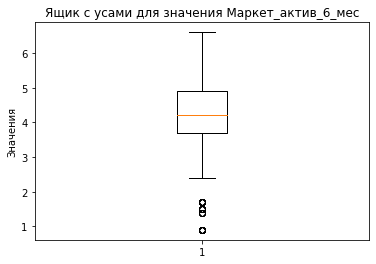

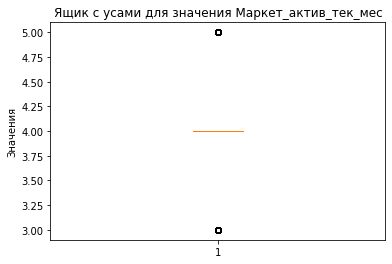

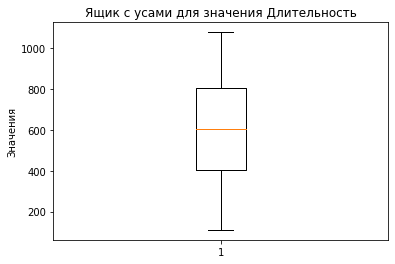

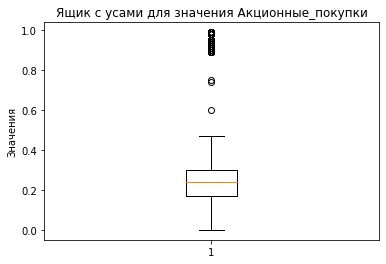

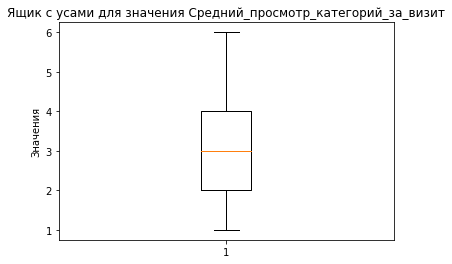

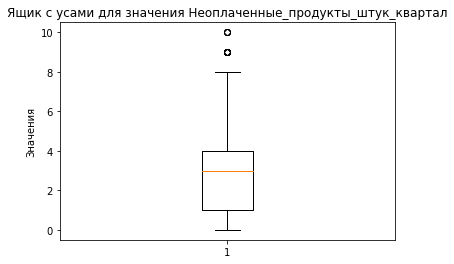

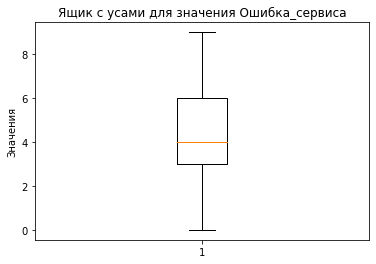

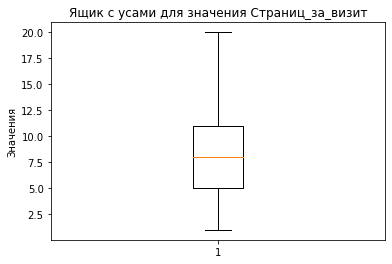

In [24]:
for i in market_file_num:
    plt.figure() 
    plt.boxplot(market_file[i])  
    plt.title(f'Ящик с усами для значения {i}')
    plt.ylabel('Значения')  
    plt.show()

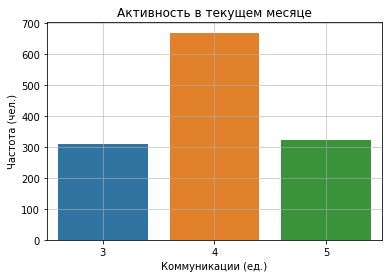

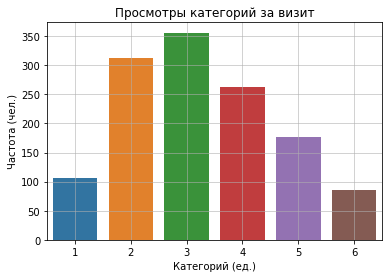

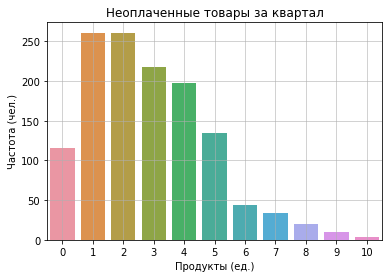

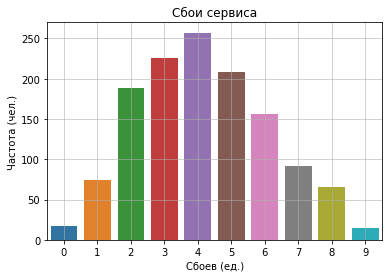

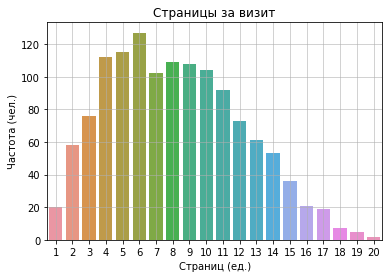

In [25]:
for feature in discrete:
    plt.figure()
    sns.countplot(data=market_file, x=feature)
    plt.title(plot_labels[feature][0])
    plt.xlabel(plot_labels[feature][1])
    plt.ylabel(plot_labels[feature][2])
    plt.grid(True, alpha=0.7)
    plt.show()

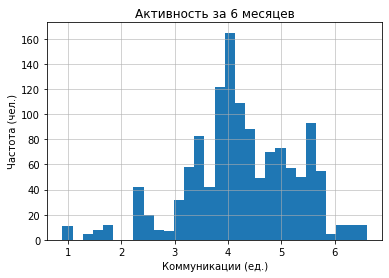

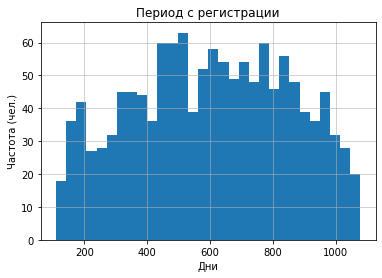

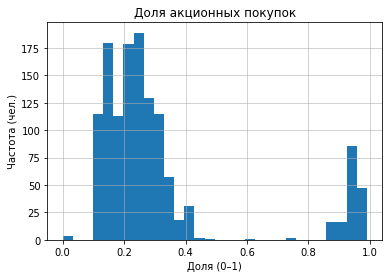

In [26]:
for feature in continuous:
    plt.figure()
    plt.hist(market_file[feature], bins=30)
    plt.title(plot_labels[feature][0])
    plt.xlabel(plot_labels[feature][1])
    plt.ylabel(plot_labels[feature][2])
    plt.grid(True, alpha=0.7)
    plt.show()


- Маркет_актив_6_мес: Согласно ящику с усами есть выбросы ниже значения 2, однако на гистграмме они не выглядят аномально, за 6 месяцев у пользователей может быть такой разброс активности, оставим данные как есть 
    
- Маркет_актив_тек_мес: Значений 4 явно больше остальных, не будем изменить данные в этом столбце 
    
- Длительность: распределение не нормальное, однако выбросов нет, оставим данные как есть, для длительности значения не вызывают подозрения 
    
- Акционные_покупки: видим два пика около значения 0,2 и 0,9. Граница между ними находится около значения 0.7. Переведем признак в категориальный, введем два значения: высокий уровень акционных покупок и низкий
    
- Средний_просмотр_категорий_за_визит: сильного дисбаланса в значениях нет, выбросов тоже, не будем изменяь этот столбец
    
- Неоплаченные_продукты_штук_квартал: чаще всего не опалачивают 1-5 покупок, есть два выброса согласно боксплоту, но по графику видно, что такие значения могут быть и не являются аномалией
    
- Ошибка_сервиса: чаще всего встречается значение 4, выбросов нет, с признаком все в порядке
    
- Страниц_за_визит: график выглядит подходящим под сам признак, выбросов нет, не изменяем столбец

In [27]:
market_file['Акционные_покупки'] = market_file['Акционные_покупки'].apply(
    lambda x : 'низкий' if x < 0.7 else 'высокий')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,низкий,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,высокий,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,низкий,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,высокий,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,высокий,Товары для детей,3,2,3,2


<b>market_money</b>

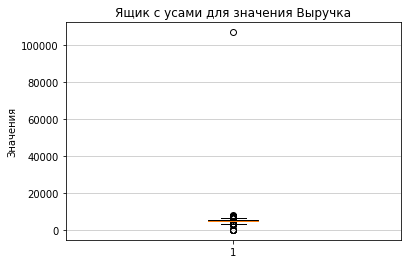

In [29]:
plt.boxplot(market_money['Выручка'])  
plt.title(f'Ящик с усами для значения Выручка')
plt.ylabel('Значения')  
plt.grid(True, axis='y', alpha=0.7)
plt.show()

Явный выброс при значении выручки 106862.2, удалим его. 

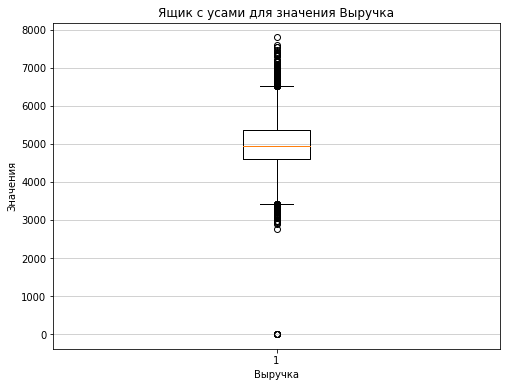

In [30]:
market_money = market_money[market_money['Выручка'] != 106862.200000]
plt.figure(figsize=(8, 6))
plt.boxplot(market_money['Выручка'])  
plt.title(f'Ящик с усами для значения Выручка')
plt.ylabel('Значения')  
plt.xlabel('Выручка')
plt.grid(True, axis='y', alpha=0.7)
plt.show()

При значении 0 также наблюдается одинокий выброс, поскольку в дальнейшем нам необходимо отфльтровать неактивных пользователей, оставим его. 

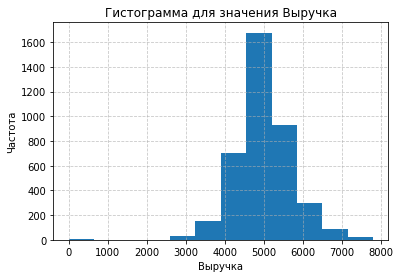

In [32]:
plt.figure()  
plt.hist(market_money['Выручка'], bins= int(math.log(3899, 2) + 1))  
plt.title(f'Гистограмма для значения Выручка')  
plt.xlabel('Выручка')  
plt.ylabel('Частота') 
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()


Ниже значения 3500 и выше 6500 наблюдается достаточно много выбросов, оставим их, поскольку удаление такого количества значений негативно скажется на исходных данных. Распределение значений не нормальное, но логически подходит под значение выручки. 

<b>market_time</b>

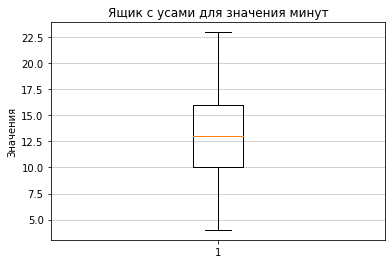

In [33]:
plt.boxplot(market_time['минут'])  
plt.title(f'Ящик с усами для значения минут')
plt.ylabel('Значения')  
plt.grid(True, axis='y', alpha=0.7)
plt.show()

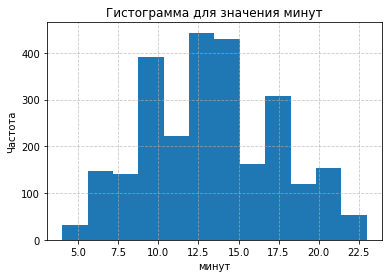

In [34]:
plt.figure()  
plt.hist(market_time['минут'], bins=int(math.log(2600, 2) + 1))  
plt.title(f'Гистограмма для значения минут')  
plt.xlabel('минут')  
plt.ylabel('Частота') 
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

Распределение не нормальное, но не вызывает подозрений, выбросов нет, оставим данные как есть. 

<b>money</b>

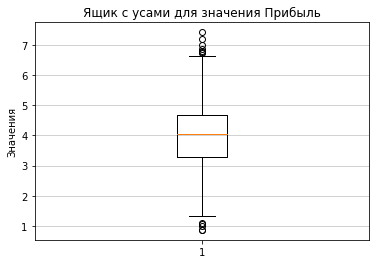

In [35]:
plt.boxplot(money['Прибыль'])  
plt.title(f'Ящик с усами для значения Прибыль')
plt.ylabel('Значения')  
plt.grid(True, axis='y', alpha=0.7)
plt.show()

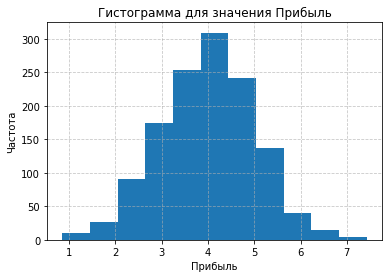

In [36]:
plt.figure()  
plt.hist(money['Прибыль'], bins=int(math.log(1300, 2) + 1))  
plt.title(f'Гистограмма для значения Прибыль')  
plt.xlabel('Прибыль')  
plt.ylabel('Частота') 
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

Распределение похоже на нормальное, выбросы имеются, но оставим их, поскольку некоторые пользователи могут приносить нетипичную прибыль и это нормально. 

Теперь перейдем к категориальным признакам. 


<b>market_file</b>

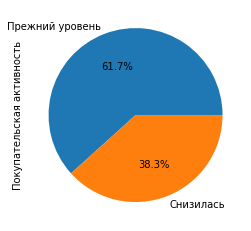

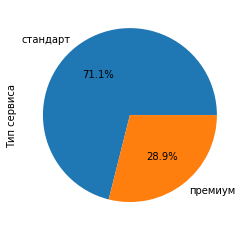

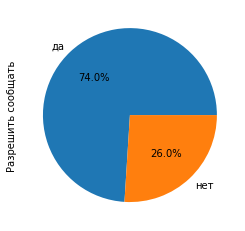

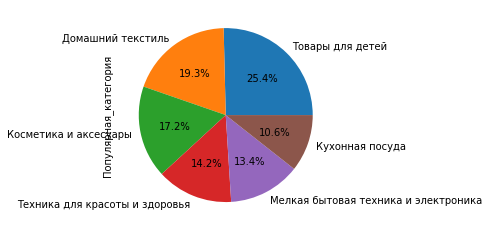

In [37]:
market_file_cat = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

for i in market_file_cat:
    plt.figure()  
    market_file[i].value_counts().plot(kind='pie', autopct='%1.1f%%')

В популярной категории небольшая разница количества признаков, всех хватает, однако в остальных стобцах количество одного признака сильно превышает другой. При написании модели, надо учесть этот факт. 

<b>market_money</b>

<AxesSubplot:ylabel='Период'>

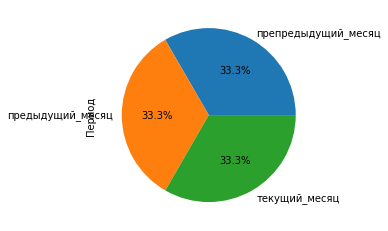

In [38]:
market_money['Период'].value_counts().plot(kind='pie', autopct='%1.1f%%')

Количество данных для всех периодов почти одинаково. 

<b>market_time</b>

<AxesSubplot:ylabel='Период'>

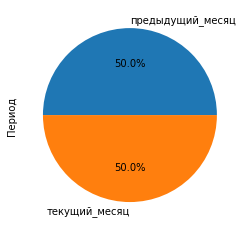

In [39]:
market_time['Период'].value_counts().plot(kind='pie', autopct='%1.1f%%')

Количество данных для обоих периодов одинаково. 

Теперь отберем клиентов с покупательской активностью не менее трёх месяцев

In [43]:
market_money.shape

(3899, 3)

In [62]:
market_file.shape

(1297, 13)

In [56]:
users_with_zero = market_money.groupby('id')['Выручка'].apply(lambda x: (x == 0).any()).reset_index()
users_with_zero = users_with_zero[users_with_zero['Выручка'] == True]
users_with_zero

,id,Выручка
0,215348,True
9,215357,True
11,215359,True


количество неактивных пользователй - 3, удалим их из таблицы market_file

In [61]:
market_file = market_file[~market_file['id'].isin(users_with_zero['id'])]
market_file.shape

(1297, 13)

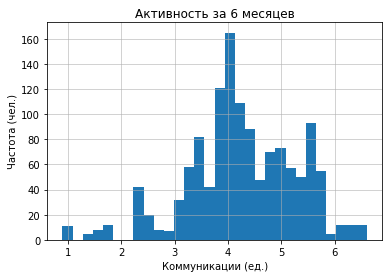

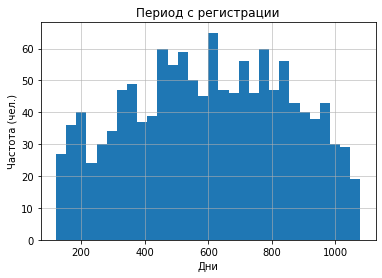

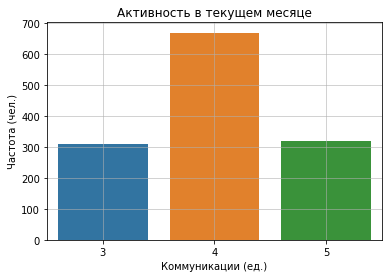

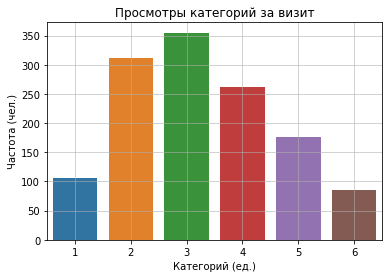

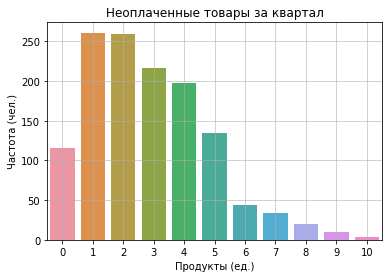

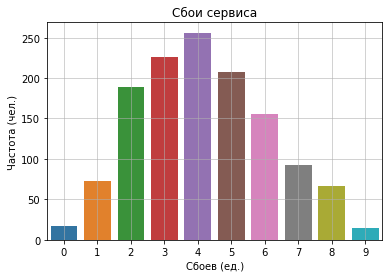

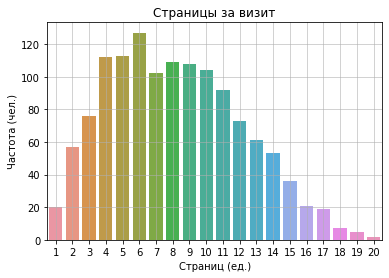

In [63]:
discrete = ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит',\
    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']

continuous = ['Маркет_актив_6_мес', 'Длительность']

for feature in continuous:
    plt.figure()
    plt.hist(market_file[feature], bins=30)
    plt.title(plot_labels[feature][0])
    plt.xlabel(plot_labels[feature][1])
    plt.ylabel(plot_labels[feature][2])
    plt.grid(True, alpha=0.7)
    plt.show()
    
for feature in discrete:
    plt.figure()
    sns.countplot(data=market_file, x=feature)
    plt.title(plot_labels[feature][0])
    plt.xlabel(plot_labels[feature][1])
    plt.ylabel(plot_labels[feature][2])
    plt.grid(True, alpha=0.7)
    plt.show()

Диаграммы числовых значений для активных пользователей визуально не отличаются от того, что было для всех. Это логично, ведь мы удалили всего трех ользователей. 

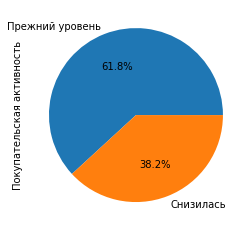

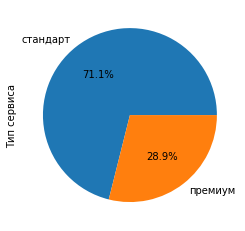

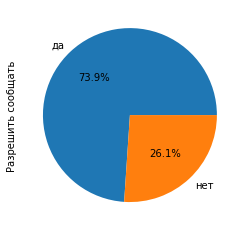

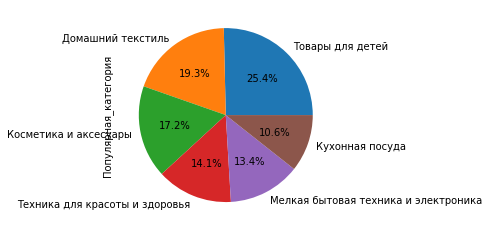

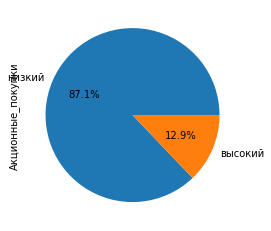

In [64]:
market_file_cat = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория', 'Акционные_покупки']

for i in market_file_cat:
    plt.figure()  
    market_file[i].value_counts().plot(kind='pie', autopct='%1.1f%%')

На соотношение категориальных признаков это явно повлияло только в случае пользовательской активности, хотя тоже не сильно. 

В итоге, мы исследовали распределение для всех признаков из таблиц, избавились в некоторых от выбросов. Часть категориальных данных сильно больше, чем других, надо учесть это при обучении модели, иначе возникнет дисбаланс классов. Отобрали активных пользователей и изучили, что изменилось для них. 

## Объединение таблиц

In [72]:
#отдельные столбцы для каждого периода для таблицы market_money
money_pivot = market_money.pivot(index='id', columns='Период', values='Выручка').reset_index()
money_pivot.columns = ['id'] + [f'Выручка_{col}' for col in money_pivot.columns if col != 'id']

#отдельные столбцы для каждого периода для таблицы market_time
time_pivot = market_time.pivot(index='id', columns='Период', values='минут').reset_index()
time_pivot.columns = ['id'] + [f'Время_{col}' for col in time_pivot.columns if col != 'id']

final_df = market_file.merge(money_pivot, on='id', how='left').merge(time_pivot, on='id', how='left')
final_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,высокий,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,низкий,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,высокий,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,высокий,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,низкий,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [73]:
print(market_file.shape)
print(money_pivot.shape)
print(time_pivot.shape)
print(final_df.shape)

(1297, 13)
(1300, 4)
(1300, 3)
(1297, 18)



Таблицы объединились верно

In [75]:
final_df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_предыдущий_месяц               0
Выручка_препредыдущий_месяц            0
Выручка_текущий_месяц                  1
Время_предыдущий_месяц                 0
Время_текущий_месяц                    0
dtype: int64

Удалим строчки, в которых обнаружились пропуски, таковая одна, скорее всего это клиент, не совершавший покупки в каждом из трех последних месяцев. 

In [76]:
final_df = final_df.dropna()
final_df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_предыдущий_месяц               0
Выручка_препредыдущий_месяц            0
Выручка_текущий_месяц                  0
Время_предыдущий_месяц                 0
Время_текущий_месяц                    0
dtype: int64

In [77]:
final_df.shape

(1296, 18)

Итак, мы объединили таблицы и получили единый датасет, в котором содержится вся информация. 

## Корреляционный анализ

In [79]:
final_df['Время_предыдущий_месяц'].unique()

array([12,  8, 11, 10,  6, 14,  9, 13,  7, 15,  5, 16, 17, 19, 18, 22, 20,
       21, 23])

In [80]:
final_df['Время_текущий_месяц'].unique()

array([10, 13, 11, 12,  7,  6,  5,  9, 14,  8, 15,  4, 16, 18, 19, 22, 20,
       17, 21, 23])

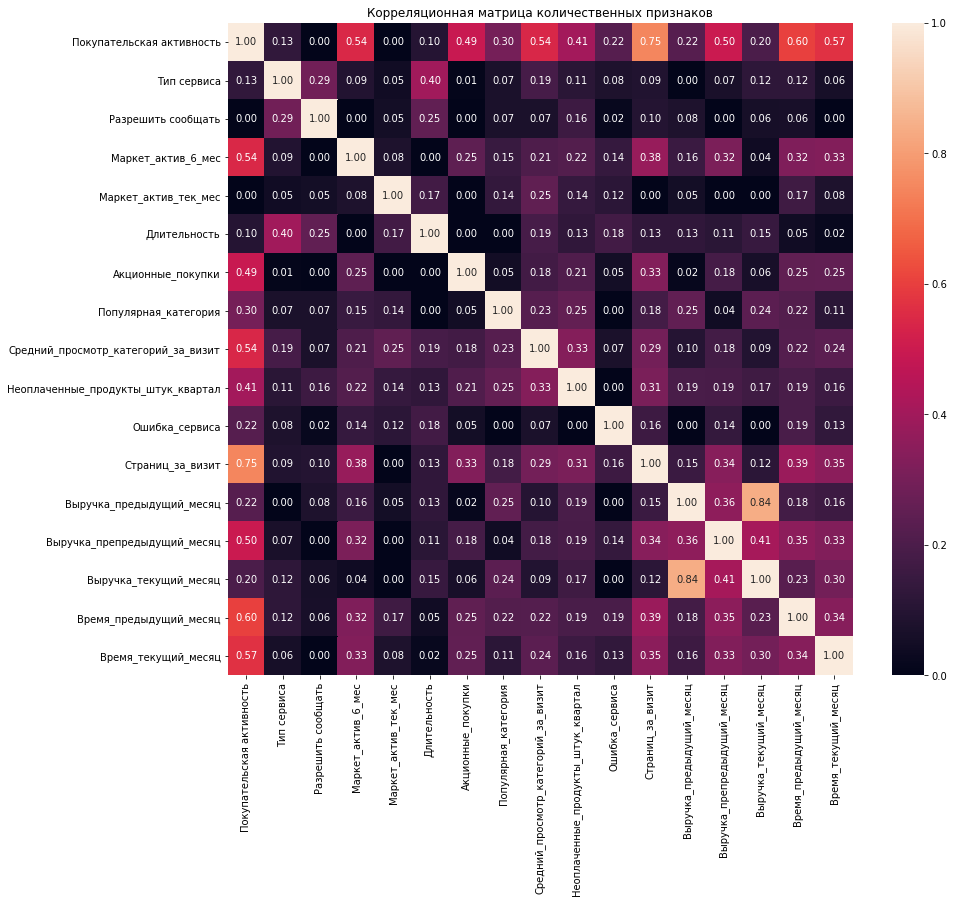

In [81]:
num_cols = ['Маркет_актив_6_мес', 'Длительность', 'Выручка_предыдущий_месяц', \
            'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']

plt.figure(figsize=(14, 12))
sns.heatmap(final_df.drop('id', axis=1).phik_matrix(interval_cols=num_cols), annot=True, fmt='.2f')
plt.title('Корреляционная матрица количественных признаков')
plt.show()

Важно исключить признаки, которые слабо или не коррелируют с нашим целевым 'Покупательская активность'

In [82]:
phik_corr = final_df.phik_matrix(interval_cols=num_cols)

correlation = phik_corr['Покупательская активность'].drop('Покупательская активность')

threshold = 0.1
features = correlation[correlation < threshold].index.tolist()

final_df = final_df.drop(columns=features)
final_df.head()                                 
                            

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable id is large: 1296. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(


,id,Покупательская активность,Тип сервиса,Маркет_актив_6_мес,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,Снизилась,премиум,4.4,высокий,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,4.9,низкий,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,3.2,высокий,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,5.1,высокий,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,3.3,низкий,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


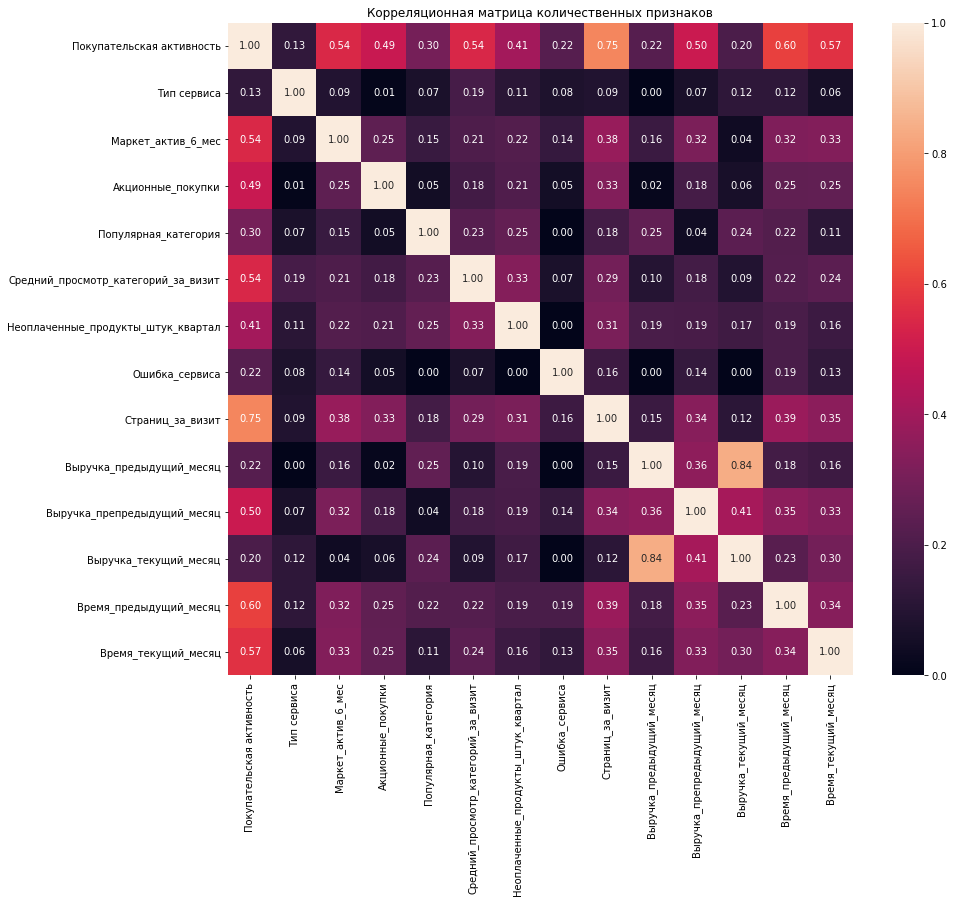

In [83]:
num_cols = ['Маркет_актив_6_мес','Выручка_предыдущий_месяц', \
            'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']

plt.figure(figsize=(14, 12))
sns.heatmap(final_df.drop('id', axis=1).phik_matrix(interval_cols=num_cols), annot=True, fmt='.2f')
plt.title('Корреляционная матрица количественных признаков')
plt.show()

Теперь нам необходимо избавиться от мультиколлинеарности. Она возникает между признаками выручка_предыдущий_месяц и выручка_текущий_месяц. Избавимся от второго. 

In [84]:
final_df = final_df.drop(['Выручка_текущий_месяц'], axis=1)
final_df.head()                                 

,id,Покупательская активность,Тип сервиса,Маркет_актив_6_мес,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,Снизилась,премиум,4.4,высокий,Товары для детей,4,4,2,5,5216.0,4472.0,12,10
1,215350,Снизилась,стандарт,4.9,низкий,Домашний текстиль,5,2,1,5,5457.5,4826.0,8,13
2,215351,Снизилась,стандарт,3.2,высокий,Товары для детей,5,0,6,4,6158.0,4793.0,11,13
3,215352,Снизилась,стандарт,5.1,высокий,Товары для детей,3,2,3,2,5807.5,4594.0,8,11
4,215353,Снизилась,стандарт,3.3,низкий,Домашний текстиль,4,1,1,4,4738.5,5124.0,10,10


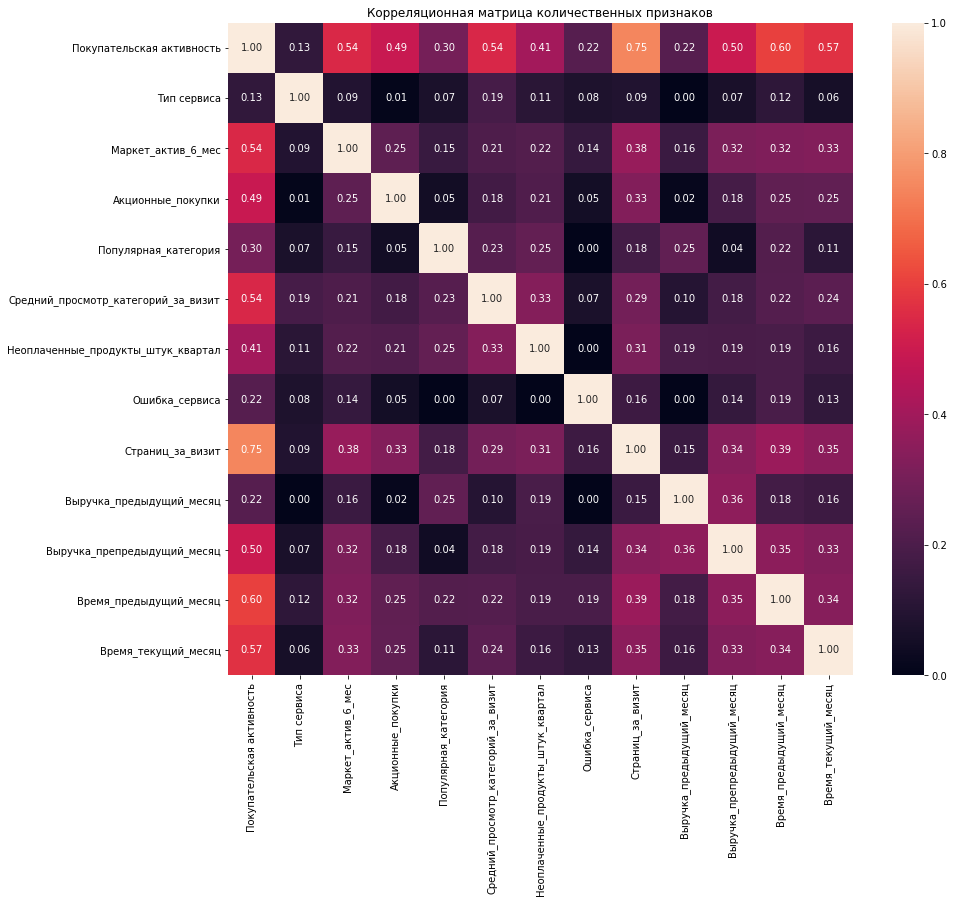

In [85]:
plt.figure(figsize=(14, 12))
sns.heatmap(final_df.drop('id', axis=1).phik_matrix(interval_cols=num_cols), annot=True, fmt='.2f')
plt.title('Корреляционная матрица количественных признаков')
plt.show()

Итак, мы удалили признаки, которые почти или совсем не коррелируют с целевым, а также избавились от мультиколлинеарности путем удаления столбца, отвечающего за выручку в текущем месяце. Теперь можем приступать к написанию пайплайнов. 

## Использование пайплайнов

Для начала разделим данные на треноировочную и тестовую выборки и создадим списки с названием признаков. 

In [88]:
final_df.shape

(1296, 14)

In [93]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = final_df.drop(columns=['id', 'Покупательская активность'])
y = final_df['Покупательская активность']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)
ohe_columns = [
                         
    'Популярная_категория'      
]

ord_columns = [
    'Тип сервиса',
    'Акционные_покупки'
]

num_columns = [
    'Маркет_актив_6_мес',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
    'Выручка_препредыдущий_месяц',
    'Выручка_предыдущий_месяц',
    'Время_предыдущий_месяц',
    'Время_текущий_месяц'
]

In [94]:
X_train.shape

(972, 12)

Теперь можем переходить к написанию пайплайна для обработки данных. 

In [95]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder( categories=[['низкий', 'высокий'], ['премиум', 'стандарт']],
                handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler())
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns),
     
    ], 
    remainder='passthrough'
)

Так как некотрых категориальных признаков сильно больше, нам нужно избавиться от дисбаланса классов, для этого воспользуемся SMOTENC, поскольку он работает с категориальными признаками. 

In [98]:
sampler = SMOTENC(categorical_features=(ohe_columns + ord_columns), random_state=RANDOM_STATE)
X_train, y_train = sampler.fit_resample(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Итак, перейдем к пайплайну обучения модели

In [99]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Нам необходимо обучить четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для подбора их гиперпарметров будем использовать метрику roc-auc, так как она хорошо работает для бинарной классификации и даёт общую оценку качества модели, независимо от порога классификации

In [100]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {        
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print("Лучшая модель:", randomized_search.best_estimator_.named_steps['models'])
print("Лучшие параметры:", randomized_search.best_params_)
print("Лучший ROC-AUC :", randomized_search.best_score_)

y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC на тестовой выборке:", test_roc_auc)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 1]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 1]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 1]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 1]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklea

Лучшая модель: SVC(kernel='poly', probability=True, random_state=42)
Лучшие параметры: {'preprocessor__num': StandardScaler(), 'models__kernel': 'poly', 'models': SVC(probability=True, random_state=42)}
Лучший ROC-AUC : 0.9166942148760331
ROC-AUC на тестовой выборке: 0.9096792460461918


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 1]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Итак, лучшей моделью оказалась SCV с параметрами 'preprocessor__num': StandardScaler(), 'models__kernel': 'poly'.
На тренировочной выборке метрика ROC-AUC равна 0.92, а на тестовой 0.9. 


## Анализ важности признаков

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 1]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 1]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Text(0, 0.5, 'Feature')

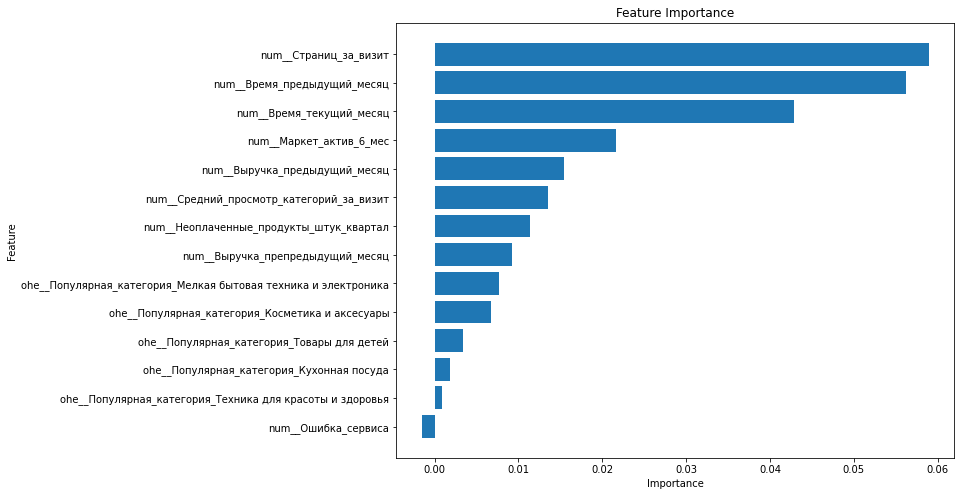

In [105]:
best_model_pipeline = randomized_search.best_estimator_
best_model = best_model_pipeline.named_steps['models']  
preprocessor = best_model_pipeline.named_steps['preprocessor']

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out().tolist()

perm_importance = permutation_importance(best_model, X_test_transformed,\
                                         y_test, n_repeats=10, random_state=RANDOM_STATE)
importance = perm_importance.importances_mean


feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')


Видим, что самыми важными признаками являются время за предыдущий и текущий месяц, а также количество страниц за визит. Есть признаки, permutation importance которых принимает отрицательное значение, возможно, стоит от них избавиться. Построим график важности с помощью метода SHAP, чтобы более подробно изучить важность признаков. 

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 1]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

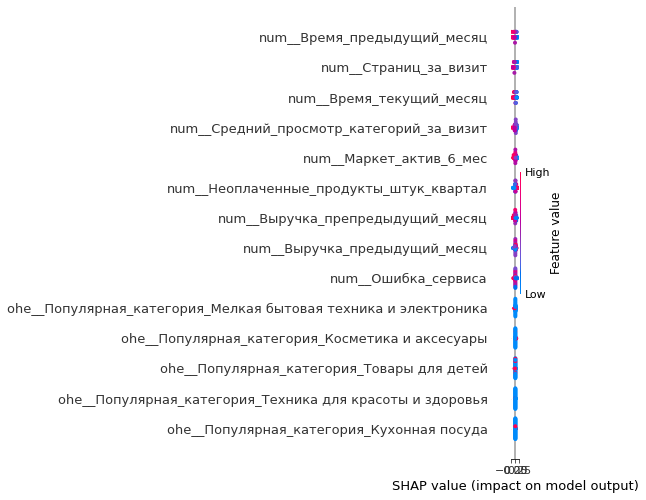

In [107]:
best_pipeline = randomized_search.best_estimator_
best_model = best_pipeline.named_steps['models']
preprocessor = best_pipeline.named_steps['preprocessor']

X_test_transformed = preprocessor.transform(X_test)

X_sample = shap.sample(X_test_transformed, 100, random_state=RANDOM_STATE)  

explainer = shap.KernelExplainer(lambda x: best_model.predict_proba(x)[:, 1], X_sample)

shap_values = explainer.shap_values(X_sample[:50])

feature_names = preprocessor.get_feature_names_out().tolist()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample[:50], feature_names=feature_names, show=False)
plt.tight_layout()


Метод SHAP не дал особо новой информации, возможно, из-за того, что наша модель SVC и плохо интерпритируется. Самыми важными признаками так и остались время за предыдущий месяц и количество страниц за визит. 

## Сегментация покупателей

In [108]:
df = final_df.merge(money, on='id')
df.head()

,id,Покупательская активность,Тип сервиса,Маркет_актив_6_мес,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц,Прибыль
0,215349,Снизилась,премиум,4.4,высокий,Товары для детей,4,4,2,5,5216.0,4472.0,12,10,4.16
1,215350,Снизилась,стандарт,4.9,низкий,Домашний текстиль,5,2,1,5,5457.5,4826.0,8,13,3.13
2,215351,Снизилась,стандарт,3.2,высокий,Товары для детей,5,0,6,4,6158.0,4793.0,11,13,4.87
3,215352,Снизилась,стандарт,5.1,высокий,Товары для детей,3,2,3,2,5807.5,4594.0,8,11,4.21
4,215353,Снизилась,стандарт,3.3,низкий,Домашний текстиль,4,1,1,4,4738.5,5124.0,10,10,3.95


Изучим как влияют признаки на значение прибыли. 

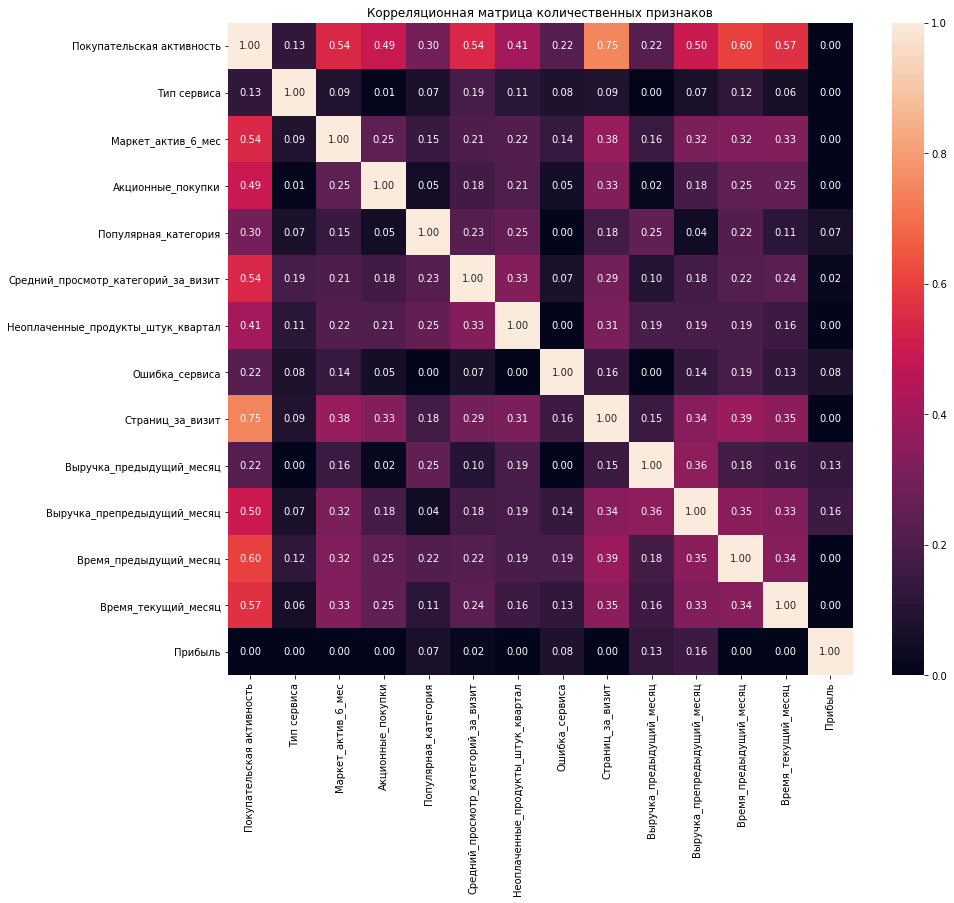

In [111]:
num_cols = ['Маркет_актив_6_мес', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц',\
            'Прибыль']

plt.figure(figsize=(14, 12))
sns.heatmap(df.drop('id', axis=1).phik_matrix(interval_cols=num_cols), annot=True, fmt='.2f')
plt.title('Корреляционная матрица количественных признаков')
plt.show()

Итак, самая высокая корреляция со значением прибыли наблюдается у выручки за препредыдущий месяц, выручки за предыдущий месяц и популярной категории. Между прибылью и покупательской активностью корреляция равна 0, выглядит подозрительно, изучим их взаимосвзяь подробнее. 

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 1]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


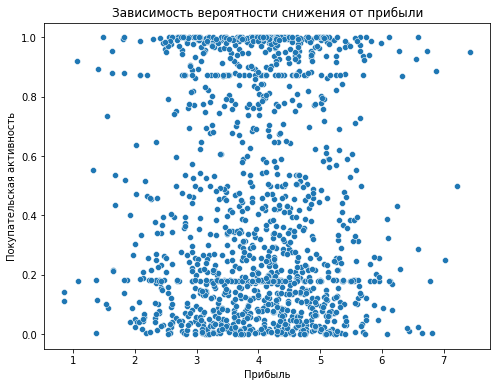

In [112]:
best_model_pipeline = randomized_search.best_estimator_
y_pred_proba = best_model_pipeline.predict_proba(X)[:, 1]  

df['Вероятность снижения активности'] = y_pred_proba

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Прибыль', y='Вероятность снижения активности')
plt.title('Зависимость вероятности снижения от прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Покупательская активность')
plt.show()

По диаграмме рассеиния видно, что есть разделение пользователей примерно около значения вероятности снижения покупательской активности 0, 6. Большое скопление пользователей, у которых вероятность сильно низкая или, наоборот, высокая. 

Нам важно изучить, из-за каких признаков покупаельская активность пользователей, приносящих прибыль, может увеличиться и упасть, поскольку именно такие клиенты в приоритете у магазинов.  

Разделим пользователей на две группы: для обеих групп будем брать приьыль>2, но одна часть- с высокой вероятностью дальнейшего снижения покупательской активностью, а другая-с низкой. 

In [113]:
df_unactive = df[(df['Вероятность снижения активности'] >= 0.6) & (df['Прибыль'] > 2)]
df_active = df[(df['Вероятность снижения активности'] < 0.6) & (df['Прибыль'] > 2)]

Теперь изучим оба сегмента пользователей по-отдельности. 

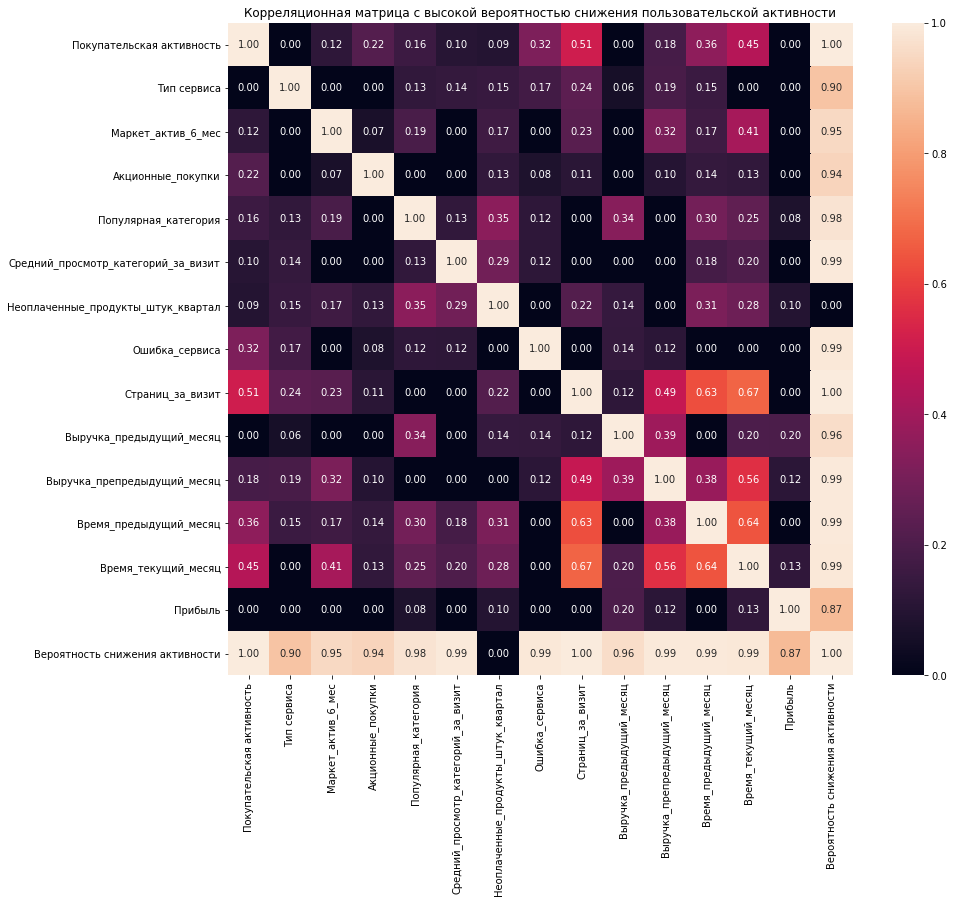

In [115]:
num_cols = ['Маркет_актив_6_мес', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц',\
            'Прибыль']

plt.figure(figsize=(14, 12))
sns.heatmap(df_unactive.drop('id', axis=1).phik_matrix(interval_cols=num_cols), annot=True, fmt='.2f')
plt.title('Корреляционная матрица с высокой вероятностью снижения пользовательской активности')
plt.show()

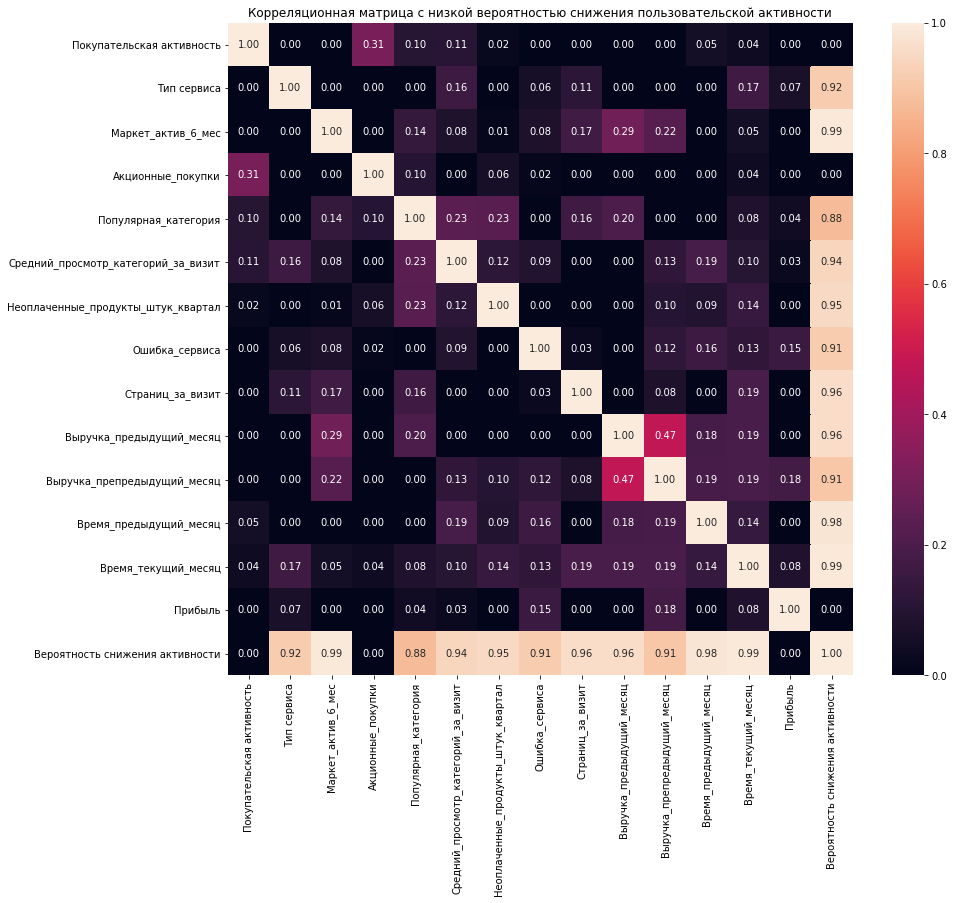

In [116]:
plt.figure(figsize=(14, 12))
sns.heatmap(df_active.drop('id', axis=1).phik_matrix(interval_cols=num_cols), annot=True, fmt='.2f')
plt.title('Корреляционная матрица с низкой вероятностью снижения пользовательской активности')
plt.show()

Итак, у пользователей с высокой вероятностью низкой активности на нее сильнее всего влияют количество страниц за висит и время за текущий месяц. Возможно, интерфейс магазин неудобен для них и им долго приходится листать страницы в поисках нужного товара, это надоедает и они уходят. 
У пользователей с низкой вероятностью низкой покупательской активности одним из важнейших факторов выступают аукционные покупки. 

Так, бизнесу стоит обратить внимание на удобство взаимодействия с сайтом или приложением магазина, чтобы пользователи быстро могли найти все необходимое, а также продумать акции, поскольку они положительно повлияли на пользовательскую активность у людей, приносящих прибыль. 
 

## Общий вывод

Задача заключалась в анализе покупательской активности клиентов и разработке рекомендаций для её повышения. Мы должны были построить модель, которая предсказывает вероятность снижения покупательской активности, определить ключевые факторы, влияющие на активность, и на основе этого провести сегментацию покупателей. Далее нужно было выбрать сегмент для более глубокого анализа и предложить меры для увеличения активности. 

У нас было 4 таблицы с данными. Проверили эти данные на пропуски и дубликаты — пропусков не было, дубликаты обработаны, все возникли из-за орфографических ошибок. Удалили признаки с низкой корреляцией с целевой переменной , чтобы уменьшить шум в модели. Для борьбы с дисбалансом классов применили SMOTENC, который учитывает категориальные признаки, и сбалансировали тренировочный набор.

Для поиска лучшей модели мы создали пайплайн, который включал:

- Предобработку данных с помощью ColumnTransformer
- Четыре модели для сравнения: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC.
Для подбора гиперпараметров у моделей мы использовали RandomizedSearchCV. Выбранная метрика для оценки — ROC-AUC, так как она хорошо подходит для задачи бинарной классификации с дисбалансом.

Лучшей моделью оказалась SVC. На кросс-валидации она показала ROC-AUC 0.92, а на тестовой выборке — ROC-AUC 0.9. Это говорит о том, что модель хорошо обобщает и способна предсказывать вероятность снижения покупательской активности.

Мы разделили пользователй на два сегмента с высокой прибылью: одни-с высокой вероятность снижения активности, вторые- с низкой. Выяснилось, что у пользователей с высокой вероятностью низкой активности значимыми являются количество страниц за висит и время за текущий месяц, а у пользователей с низкой вероятностью низкой покупательской активности одним из важнейших факторов выступают аукционные покупки. 

Магазину стоит обращать внимание на указанные признаки. Для повышения прибыли магазину стоит задуматься о:
- изменении интерфейса
- создании рекомендательной системы
- проводить акции